# COVID screening lab simulation

This version of the simulation is based on the following process description, with the option to adjust the batch size of the hat stage, e.g. 93 or 372 tubes as on one process step).

<img src="figs/process_10.png">

## Requirements and module imports

Code in this simulation uses a standard Anaconda Python environment (https://www.anaconda.com/distribution/#download-section). Additionally this model uses SimPy3 (https://simpy.readthedocs.io/en/latest/). Install SimPy3 with `pip install 'simpy<4'`.

In [1]:
import simpy
import inspect
from sim_utils.replication import Replicator
from sim_utils.parameters import Scenario

## Set up scenarios

Parameters defined in scenarios will overwrite default values in the parameters python file.

In [2]:
# Set up a dictionary to hold scenarios
scenarios = {}

# Baseline sceanrio (model defaults)
scenarios['base'] = Scenario(
    
    # Demand
    samples_per_day = 15000,

    # Proportion of samples that are high priority
    high_priority = 0.50,
    
    # Which delivery schedule to use ('Single, 'Even', 'Custom')
    delivery_schedule_name = 'Single',
    
    # Process check intervals (if not 1 minute). Must be integer multiple of 1.
    process_intervals = {'transfer_1': 10},
    
    # Batch sizing for stages (collate for job then re-split)
    heat_batch_size = 4,
    rna_extraction_batch_size = 3,
    transfer_1_batch_size = 4,
    
    run_days = 10,
    warm_up_days = 2
)

## Run model

                                                                               
Output results
--------------
                                    min          mean     median       max
                                 Result        Result     Result    Result
result_type               name                                            
demand_met                base      1.0      1.000000      1.000      1.00
input                     base  14973.0  14973.000000  14973.000  14973.00
max_process_time_hours    base     32.0     35.335333     34.850     39.62
median_process_time_hours base     23.1     30.990333     31.285     32.00
output                    base  15028.8  15028.800000  15028.800  15028.80



Resources used
--------------
                                Available       Used  Utilisation
resource                  name                                   
beckman_rna_extraction    base         28   7.488028     0.267430
human_data_analysis       base         10   1.944366     0.

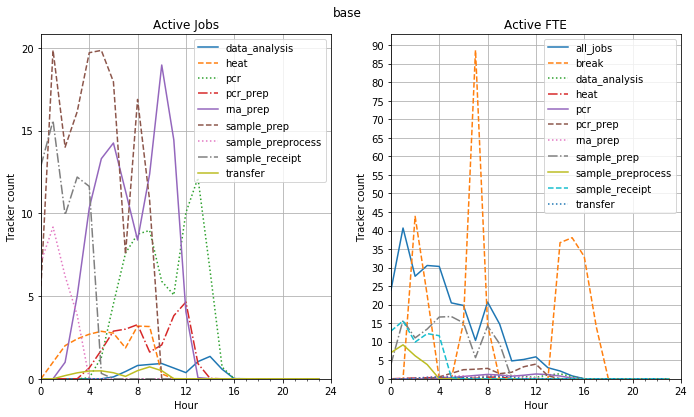

In [3]:
replications = 30
replications = Replicator(scenarios, replications)
replications.run_scenarios()

## Show model default parameters

Run the code below to model defaults these are over-ridden by scenarios).

In [4]:
print(inspect.getsource(Scenario.__init__))

    def __init__(self, *initial_data, **kwargs):

        # Set default values
        # 16/4/2020 Adjust parameters so that day starts with FTE arrival

        # Proportion high priority
        self.high_priority = 0.25

        # Work arrival
        self.samples_per_day = 18600
        # List of sample arrival times (hours from start of day)
        self.delivery_schedule_name = 'Single'
        self.basic_batch_size = 93

        # Day and run parameters
        # 16/4/2020 Model is designed to run primarily in single days
        self.day_duration = 1440
        self.run_days = 2
        self.warm_up_days = 2

        # Breaks for people (high priority job, but does not interrupt work)
        # Times from start of FTE day (6am)
        self.tea_break_times = [2 * 60, 16 * 60]
        self.meal_break_times = [6.5 * 60, 14 * 60]
        # Spread start of break for people randomly after set start times
        self.break_start_spread = 60

        # break duration is a uniform dis